<a href="https://colab.research.google.com/github/sofials2002/SOFIA/blob/master/DiD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Difference-in-Differences

This notebook shows how to estimate a difference-in-differences using the `pyfixest` package. First we show the case of one cohort treated and use TWFE to estimate the effect. Then we show the case of multiple cohorts treated and use modern approaches for estimation.

For more information, see the [documentation](https://py-econometrics.github.io/pyfixest/difference-in-differences.html).

In [1]:
!pip install pyfixest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.6
    Uninstalling tqdm-4.66.6:
      Successfully uninstalled tqdm-4.66.6


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import pyfixest as pf

import warnings
warnings.simplefilter('ignore') #why do we include this?

%config InlineBackend.figure_format = "retina"

## 2x2 Design

The data is from the `pyfixest` package and is a panel data set with the following variables:
 - `unit`: the unit identifier
 - `year`: the time identifier
 - `treat`: a binary variable indicating whether the unit is treated
 - `Y`: the outcome variable

In [5]:
from pyfixest.utils.dgps import get_sharkfin #“sharkfin” pattern might describe a graph where the data rises sharply and then drops off quickly, resembling the shape of a shark’s fin.

df_one_cohort = get_sharkfin()
df_one_cohort.head()


,unit,year,treat,Y,ever_treated
0,0,0,0,1.629307,0
1,0,1,0,0.825902,0
2,0,2,0,0.208988,0
3,0,3,0,-0.244739,0
4,0,4,0,0.804665,0


We can use `panelview` to visualize how many treated and control units we have in each year

<Axes: title={'center': 'Treatment Assignment Cohorts'}, xlabel='Year', ylabel='Cohort'>

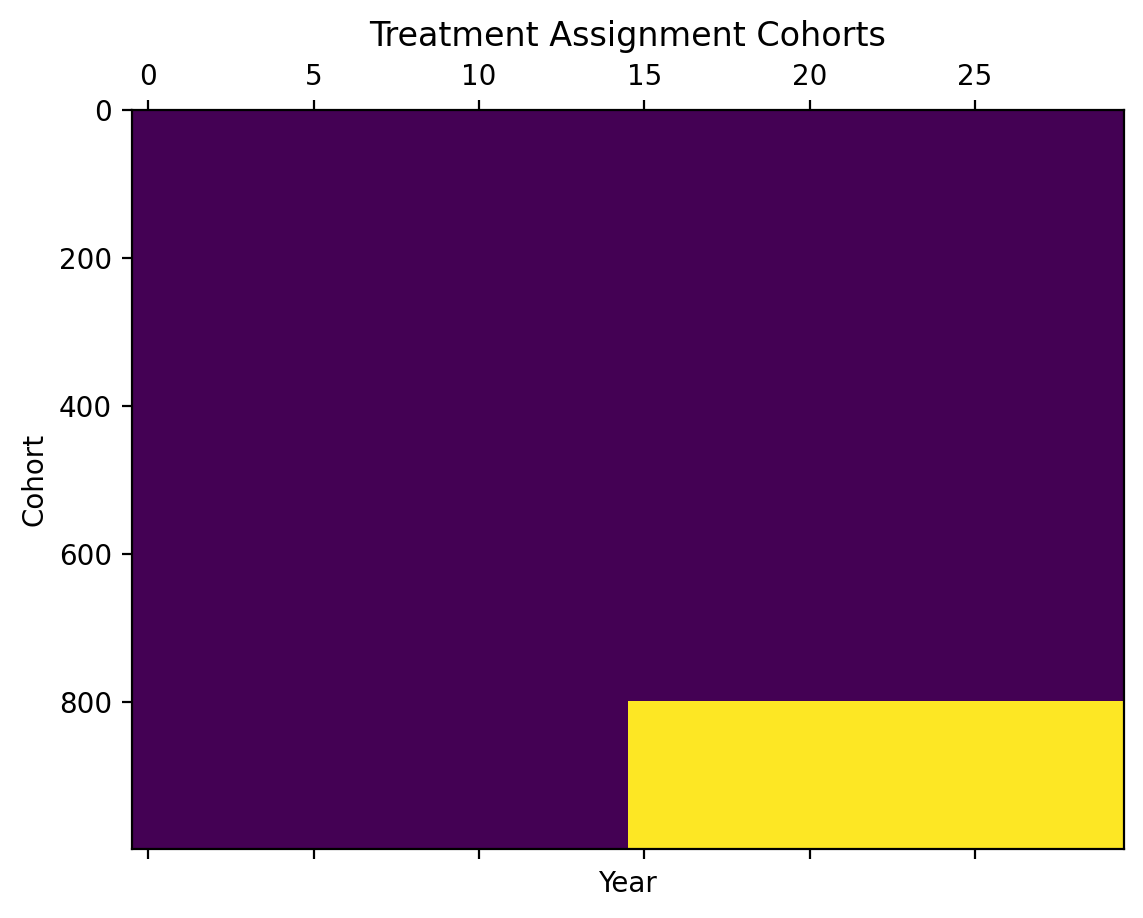

In [6]:
pf.panelview(
    df_one_cohort,
    unit="unit",
    time= 'year',
    treat= 'treat',
    sort_by_timing=True,
    ylab="Cohort",
    xlab="Year",
    title="Treatment Assignment Cohorts",
    figsize=(0.5, 0.5),
)

And plot the evolution of the outcome variable for treated and control units

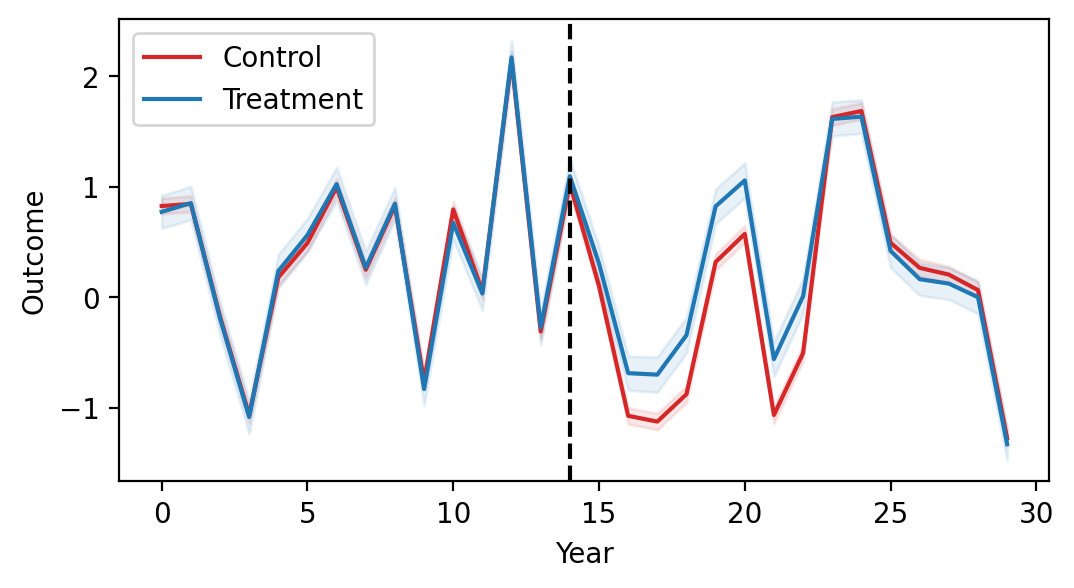

In [11]:
fig, ax= plt.subplots(figsize=(6,3))

#calculate means and standard errors:
means = df_one_cohort.groupby(['year', 'ever_treated'])['Y'].mean().unstack()
std_errors = df_one_cohort.groupby(['year', 'ever_treated'])['Y'].sem().unstack()

#plot means:
means.plot(ax=ax, color=['tab:red', 'tab:blue'])

#add standard errors:
ax.fill_between(means.index, means.iloc[:,0] - std_errors.iloc[:,0], means.iloc[:,0] + std_errors.iloc[:,0], color='tab:red', alpha=0.1)
ax.fill_between(means.index, means.iloc[:,1] - std_errors.iloc[:,1], means.iloc[:,1] + std_errors.iloc[:,1], color='tab:blue', alpha=0.1)

#Add legend, vertical line, labels, and show plot:
plt.legend(loc="upper left", labels=["Control", "Treatment"])
plt.axvline(x=14, color="black", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Outcome")
plt.show()


Under the parallel trends assumption, we can identify the average treatment effect on the treated (ATT) as the difference in the average outcome between treated and control units before and after the treatment.

Parallel trends: the average outcome of treated and control units would have followed the same trend in the absence of the treatment.

To estimate the ATT, we can use a TWFE model with the following formula:

$$
Y_{it} = \alpha_i + \lambda_t + \tau \cdot \text{W}_{it} + \epsilon_{it}
$$

where:
- $Y_{it}$ is the outcome variable
- $\alpha_i$ is the unit fixed effect
- $\lambda_t$ is the time fixed effect
- $\tau$ is the treatment effect
- $\text{W}_{it}$ is the treatment indicator

In [17]:
fit_static_twfe = pf.feols("Y ~ treat | unit + year", df_one_cohort, vcov={"CRV1": "unit"})
fit_static_twfe.summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: unit+year
Inference:  CRV1
Observations:  30000

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| treat         |      0.206 |        0.052 |     3.929 |      0.000 |  0.103 |   0.308 |
---
RMSE: 0.701 R2: 0.905 R2 Within: 0.003 


Now we use an event study to obtain separate treatment effects for each time period.

$$
Y_{it} = \alpha_i + \lambda_t + \sum_{k \neq 0} \tau_k \cdot \text{W}_{it}^{(k)} + \epsilon_{it}
$$

where $\text{W}_{it}^{(k)}$ is the treatment indicator for time period $k$.

In [18]:
fit_dynamic_twfe = pf.feols("Y ~ i(year, ever_treated, ref = 14) | unit + year",
                            df_one_cohort, vcov={"CRV1": "unit"})
fit_dynamic_twfe.summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: unit+year
Inference:  CRV1
Observations:  30000

| Coefficient                                          |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------------------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| C(year, contr.treatment(base=14))[T.0]:ever_treated  |     -0.118 |        0.075 |    -1.578 |      0.115 | -0.265 |   0.029 |
| C(year, contr.treatment(base=14))[T.1]:ever_treated  |     -0.059 |        0.080 |    -0.736 |      0.462 | -0.215 |   0.098 |
| C(year, contr.treatment(base=14))[T.2]:ever_treated  |     -0.080 |        0.081 |    -0.983 |      0.326 | -0.240 |   0.080 |
| C(year, contr.treatment(base=14))[T.3]:ever_treated  |     -0.084 |        0.083 |    -1.015 |      0.311 | -0.246 |   0.078 |
| C(year, contr.treatment(base=14))[T.4]:ever_treated  |     -0.009 |        0.081 |    -0.108 |      0.914 | -0.167 |   0.150

In [19]:
from pyfixest.report.utils import rename_event_study_coefs

fit_dynamic_twfe.iplot(
    coord_flip=False,
    title="Event Study",
    figsize=[1200, 400],
    yintercept=0,
    xintercept=13.5,
    labels=rename_event_study_coefs(fit_dynamic_twfe._coefnames),
)

In [20]:
fit_dynamic_twfe.iplot(
    coord_flip=False,
    title="Event Study",
    figsize=[1200, 400],
    yintercept=0,
    xintercept=13.5,
    joint="both",
    labels=rename_event_study_coefs(fit_dynamic_twfe._coefnames),
)

## Staggered Adoption

In [21]:
# multi-cohort adoption data
df_multi_cohort = url = "https://raw.githubusercontent.com/s3alfisc/pyfixest/master/pyfixest/did/data/df_het.csv"
df_multi_cohort = pd.read_csv(url)
df_multi_cohort.tail()

,unit,state,group,unit_fe,g,year,year_fe,treat,rel_year,rel_year_binned,error,te,te_dynamic,dep_var
46495,1500,2,Group 3,0.528683,0,2016,0.063835,False,-inf,6,2.108508,0,0.0,2.701026
46496,1500,2,Group 3,0.528683,0,2017,0.329420,False,-inf,6,0.863615,0,0.0,1.721719
46497,1500,2,Group 3,0.528683,0,2018,-0.111975,False,-inf,6,-0.331834,0,0.0,0.084874
46498,1500,2,Group 3,0.528683,0,2019,-0.008949,False,-inf,6,-0.552170,0,0.0,-0.032436
46499,1500,2,Group 3,0.528683,0,2020,-0.374951,False,-inf,6,-0.071595,0,0.0,0.082138


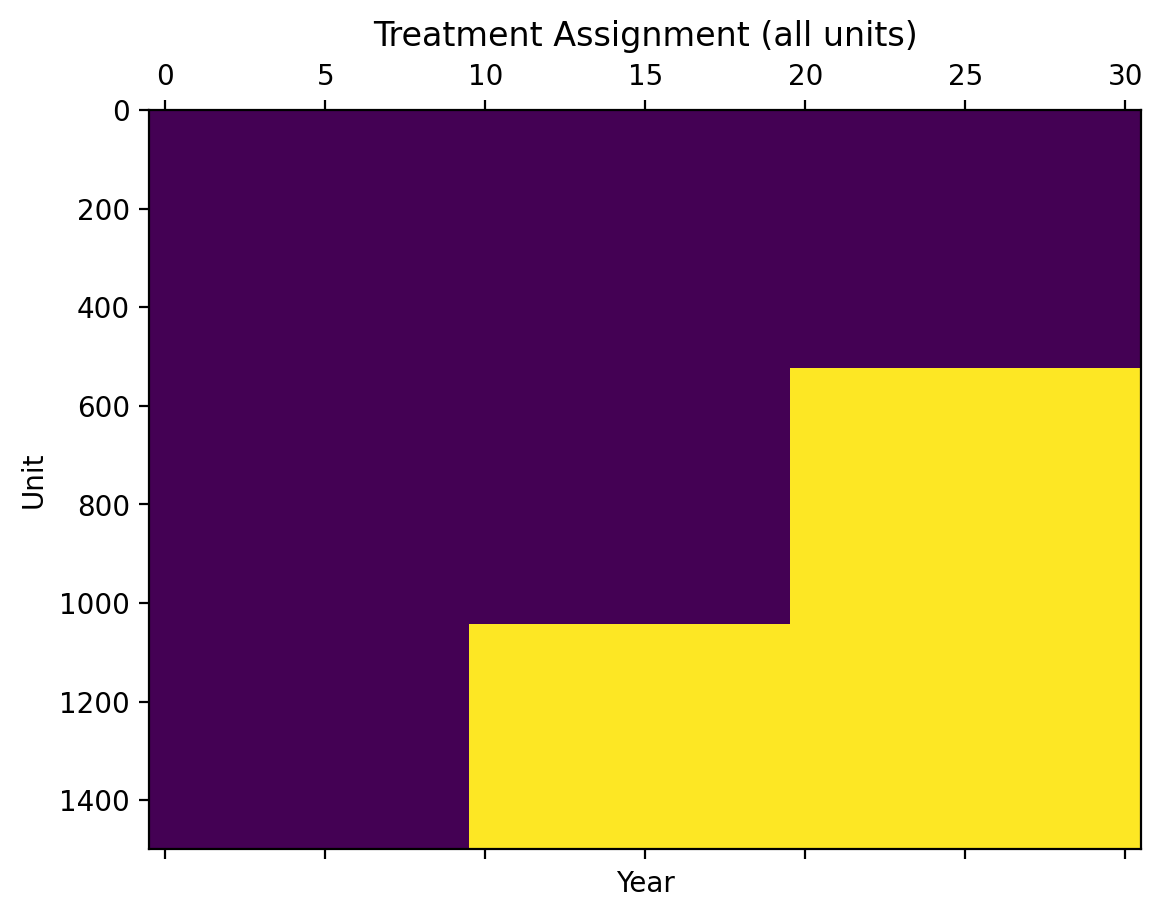

In [22]:
pf.panelview(
    df_multi_cohort,
    unit="unit",
    time="year",
    treat="treat",
    sort_by_timing=True,
    ylab="Unit",
    xlab="Year",
    title="Treatment Assignment (all units)",
    figsize=(0.5, 0.5),
)

plt.show()

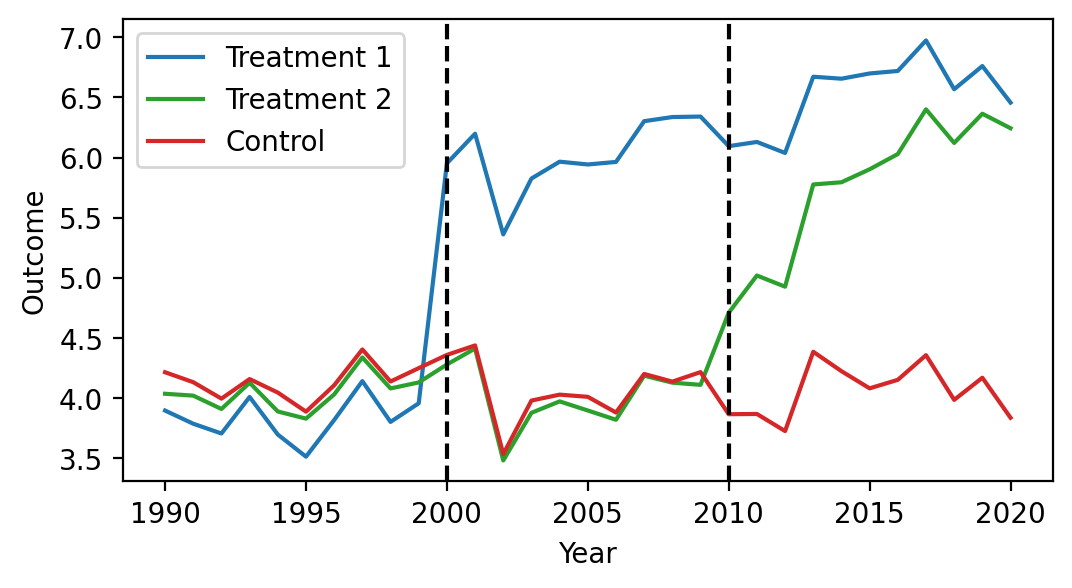

In [23]:
fig, ax = plt.subplots(figsize=(6, 3))
df_multi_cohort.groupby(["year", "group"])["dep_var"].mean().unstack().plot(ax=ax, color=['tab:blue', 'tab:green', 'tab:red'])
plt.legend(loc="upper left", labels=["Treatment 1", "Treatment 2", "Control"])
plt.axvline(x=2000, color="black", linestyle="--")
plt.axvline(x=2010, color="black", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Outcome")
plt.show()